# Tuning curves

One of the most common ways
to tweak models
and debug failures
is to look at the **tuning curves**
of the neurons in an ensemble.
The tuning curve tells us
how each neuron responds
to an incoming input signal.

## 1-dimensional ensembles

The tuning curve is easiest
to interpret in the one-dimensional case.
Since the input is a single scalar,
we use that value as the x-axis,
and the neuron response as the y-axis.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nengo
from nengo.dists import Choice
from nengo.utils.ensemble import response_curves, tuning_curves

Text(0.5, 0, 'Input scalar, x')

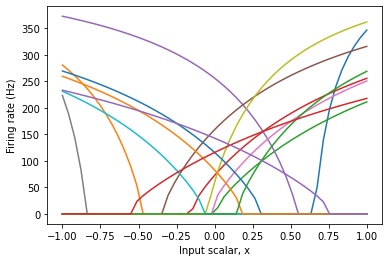

In [2]:
model = nengo.Network()
with model:
    ens_1d = nengo.Ensemble(15, dimensions=1)
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ens_1d, sim)

plt.figure()
plt.plot(eval_points, activities)
# We could have alternatively shortened this to
# plt.plot(*tuning_curves(ens_1d, sim))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")

Each coloured line represents the response on one neuron.
As you can see, the neurons cover the space pretty well,
but there is no clear pattern to their responses.

If there is some biological or functional reason
to impose some pattern to their responses,
we can do so by changing the parameters
of the ensemble.

Text(0.5, 0, 'Input scalar, x')

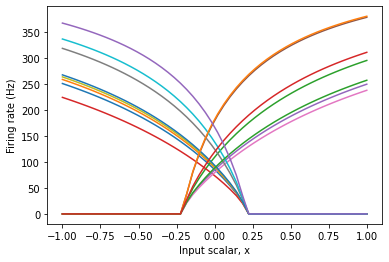

In [3]:
ens_1d.intercepts = Choice([-0.2])  # All neurons have x-intercept -0.2
with nengo.Simulator(model) as sim:
    plt.figure()
    plt.plot(*tuning_curves(ens_1d, sim))

plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")

Now, there is a clear pattern to the tuning curve.
However, note that some neurons start firing at
-0.2, while others stop firing at 0.2.
This is because the input signal, `x`,
is multiplied by a neuron's *encoder*
when it is converted to input current.

We could further constrain the tuning curves
by changing the encoders of the ensemble.

Text(0.5, 0, 'Input scalar, x')

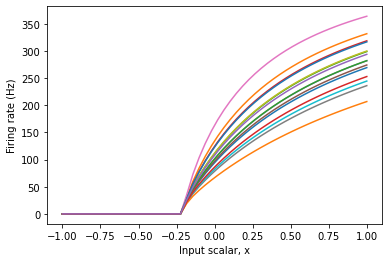

In [4]:
ens_1d.encoders = Choice([[1]])  # All neurons have encoder [1]
with nengo.Simulator(model) as sim:
    plt.figure()
    plt.plot(*tuning_curves(ens_1d, sim))

plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")

This gives us an ensemble of neurons
that respond very predictably to input.
In some cases, this is important to the
proper functioning of a model,
or to matching what we know about
the physiology of a brain area or neuron type.

## 2-dimensional ensembles

In a two-dimensional ensemble,
the input is represented by two scalar values,
meaning that we will need three axes
to represent its tuning curve;
two for input dimensions, and one for the neural activity.

Fortunately, we are able to plot data in 3D.

If there is a clear pattern to the tuning curves,
then visualizing them all is (sort of) possible.

Text(0.5, 0, 'Firing rate (Hz)')

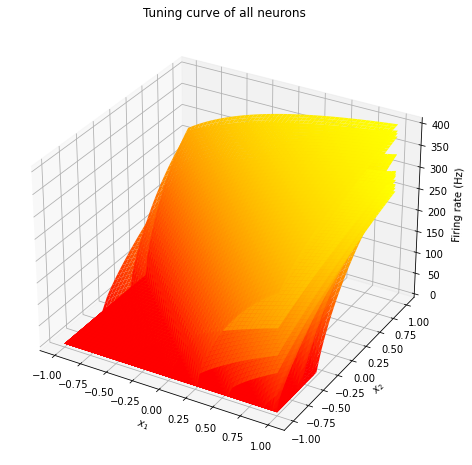

In [5]:
model = nengo.Network()
with model:
    ens_2d = nengo.Ensemble(15, dimensions=2, encoders=Choice([[1, 1]]))
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ens_2d, sim)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="3d")
ax.set_title("Tuning curve of all neurons")
for i in range(ens_2d.n_neurons):
    ax.plot_surface(
        eval_points.T[0], eval_points.T[1], activities.T[i], cmap=plt.cm.autumn
    )
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("Firing rate (Hz)")

But in most cases, for 2D ensembles,
we have to look at each neuron's tuning curve separately.

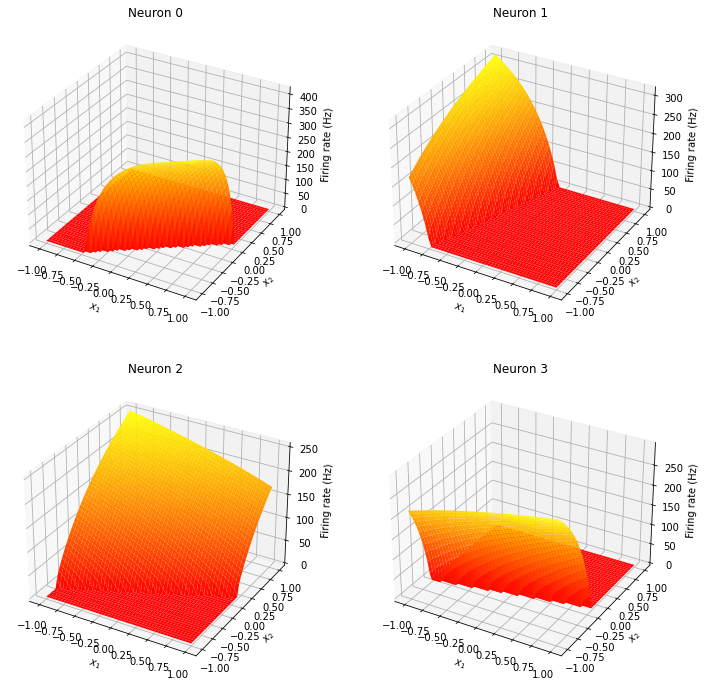

In [6]:
ens_2d.encoders = nengo.Default
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ens_2d, sim)

plt.figure(figsize=(12, 12))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1, projection=Axes3D.name)
    ax.set_title(f"Neuron {i}")
    ax.plot_surface(
        eval_points.T[0], eval_points.T[1], activities.T[i], cmap=plt.cm.autumn
    )
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("Firing rate (Hz)")

## N-dimensional ensembles

The `tuning_curve` function accepts
ensembles of any dimensionality,
and will always return `eval_points` and `activities`.
However, for ensembles of dimensionality
greater than 2, these are large arrays
and it becomes nearly impossible
to visualize them.

There are two main approaches
to investigating the tuning curves
of ensembles of arbitrary dimensionality.

### Clamp some axes

In many cases, we only care about
the neural sensitivity to one or two dimensions.
We can investigate those dimensions specifically
by only varying those dimensions,
and keeping the rest constant.

To do this, we will use the `inputs` argument
to the `tuning_curves` function,
which allows us to define
the input signals that
will drive the neurons
to determine their activity.
In other words, we are specifying
the `eval_point` parameter
to generate the `activities`.

Text(0.5, 0, '$x_0$')

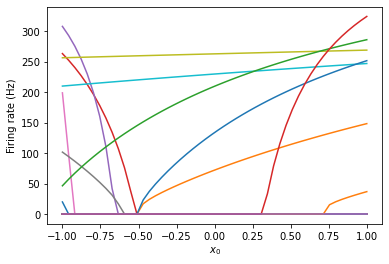

In [7]:
model = nengo.Network()
with model:
    ens_3d = nengo.Ensemble(15, dimensions=3)

inputs = np.zeros((50, 3))
# Vary the first dimension
inputs[:, 0] = np.linspace(-float(ens_3d.radius), float(ens_3d.radius), 50)
inputs[:, 1] = 0.5  # Clamp the second dimension
inputs[:, 2] = 0.5  # Clamp the third dimension

with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ens_3d, sim, inputs=inputs)

assert eval_points is inputs  # The inputs will be returned as eval_points

plt.figure()
plt.plot(inputs.T[0], activities)
plt.ylabel("Firing rate (Hz)")
plt.xlabel("$x_0$")

Notice that these tuning curves
are much more broad than those
in the 1-dimensional case.
This is because some neurons are not
very sensitive to
the dimension that are varying,
and are instead sensitive
to one or two of the other dimensions.
If we wanted these neurons
to be more sharply tuned
to this dimension,
we could change their encoders
to be more tuned to this dimension.

### Response curves

If all else fails,
we can still get some information
about the tuning properties
of the neurons in the ensemble
using the **response curve**.
The response curve is similar to the tuning curve,
but instead of looking at the neural response
to a particular input stimulus,
we are instead looking at its response
to (relative) injected current.
This is analogous to the tuning curves
with the inputs aligned to the
preferred directions of each neuron.

Text(0.5, 0, 'x along preferred direction')

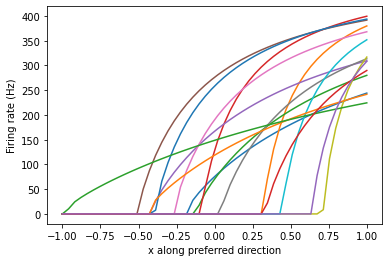

In [8]:
model = nengo.Network()
with model:
    ens_5d = nengo.Ensemble(15, dimensions=5)
with nengo.Simulator(model) as sim:
    plt.figure()
    plt.plot(*response_curves(ens_5d, sim))

plt.ylabel("Firing rate (Hz)")
plt.xlabel("x along preferred direction")